In [46]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

nz=101; nx=101; h=20

nt=500; dt=0.006
ntr=1

def read(filename,n=None):
    if n==None:
        nn=(nx,nz)
    else:
        nn=n
    return np.fromfile(filename,dtype='float32').reshape(nn).T

tmppath='/home/wzhou/'
if not os.path.exists(tmppath): tmppath='/home/zhouw/'
tmppath=tmppath+'tmp'
    
def read_su(filename):
    !sustrip < $filename > $tmppath outpar=outpar
    data=read(tmppath,n=(ntr,nt))
    !rm $tmppath
    return data

def imshow(data,perc=None,clip=None,clipmin=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def amp_spec(data):
    return abs(np.fft.rfft(data))

## FWD

rm: cannot remove 'rho1': No such file or directory
rm: cannot remove 'rho2': No such file or directory


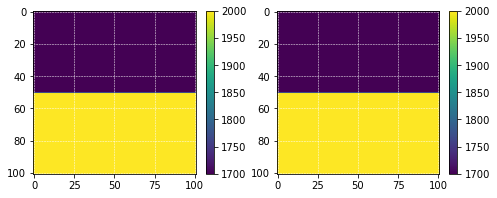

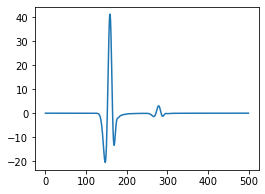

In [57]:
## with reflections
!makevel nz=51 nx=$nx v000=1700 > vp1
!makevel nz=50 nx=$nx v000=2000 > vp2
!cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
!rm vp1 vp2 rho1 rho2 tmp*

!makevel nz=1 nx=$nx v000=100 > topo
#!makevel nz=1 nx=$nx v000=400 > topo

## plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('model'))

!../../exe/FWD setup.in > out_fwd

!rm -r results_fwd; mv results  results_fwd

## plot
plt.subplot(1,2,2); imshow(read('model'))

plt.figure(figsize=(4,3))
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))

## FWI gradient for vp

In [58]:
# # with reflections
# !makevel nz=51 nx=$nx v000=1600 > vp1
# !makevel nz=50 nx=$nx v000=1800 > vp2
# !cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
# !rm vp1 vp2 rho1 rho2 tmp*

# # w/o reflections
!makevel nz=$nz nx=$nx v000=1600 > model

# !cp setup.in setup_grad.in
# !echo "PARAMETER           'vp:1500:2000'" >> setup_grad.in
# !echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_grad.in
# !echo "JOB                 'gradient'" >> setup_grad.in

!../../exe/FWI setup_grad.in  > out_grad
!rm -r results_grad; mv results results_grad

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


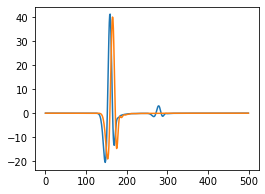

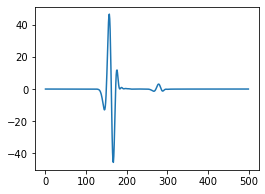

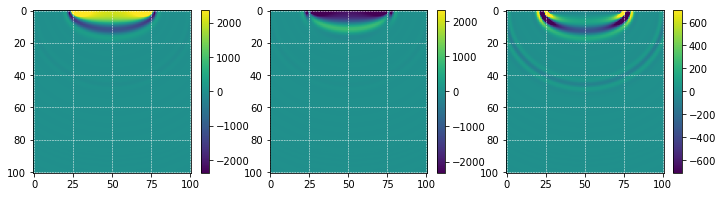

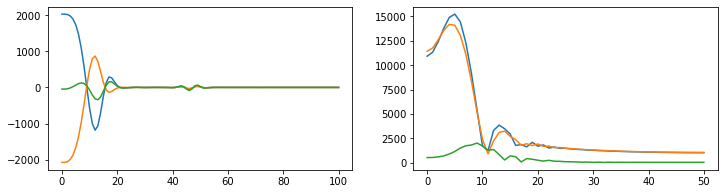

In [59]:
plt.figure(figsize=(4,3))
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_grad/dsyn_Shot0001.su'))

plt.figure(figsize=(4,3))
plt.plot(read_su('results_grad/dadj_Shot0001.su'))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);tmp1=read('results_grad/gikpa')/(1700**2); imshow(tmp1,perc=99)
plt.subplot(1,3,2);tmp2=read('results_grad/gbuo');  imshow(tmp2,perc=99)
plt.subplot(1,3,3);imshow(tmp1+tmp2, perc=99) #scaled gradient for rho, under vp-rho

plt.figure(figsize=(12,3))
plt.subplot(1,2,1); plt.plot(tmp1[:,50]); plt.plot(tmp2[:,50]); plt.plot(tmp1[:,50]+tmp2[:,50])
plt.subplot(1,2,2); plt.plot(amp_spec(tmp1[:,50])); plt.plot(amp_spec(tmp2[:,50])); plt.plot(amp_spec(tmp1[:,50]+tmp2[:,50]))

# plt.figure(figsize=(12,3))
# plt.subplot(1,3,1);imshow(signal.medfilt2d(tmp1))
# plt.subplot(1,3,2);imshow(signal.medfilt2d(tmp2))
# plt.subplot(1,3,3);imshow(signal.medfilt2d(tmp1)-signal.medfilt2d(tmp2))

### GradientTest

In [72]:
!makevel nz=$nz nx=$nx v000=1600 > model
!makevel nz=1   nx=$nx v000=100  > topo

#!make

!cp setup.in setup_test.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test.in
!echo "PARAMETER           'vp:1500:2000'" >> setup_test.in
#!echo "JOB                 gradient" >> setup_test.in
!echo "FILE_TOPO            topo" >> setup_test.in
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   5.08471012       5.08471680     -0.667572021     -0.635924697      0.952593386     T
 1st cond   9.99999975E-05   5.08465433       5.08471680     -0.624656677     -0.635924697       1.01803875     T
 1st cond   1.00000005E-03   5.08408022       5.08471680     -0.636577547     -0.635924697      0.998974442     T
 1st cond   9.99999978E-03   5.07837105       5.08471680     -0.634574890     -0.635924697       1.00212705     T
 1st cond  0.100000001       5.02189970       5.08471680     -0.628170967     -0.635924697       1.01234329     T
 1st cond   1.00000000       4.52265024       5.08471680     -0.562066555     -0.635924697       1.13140464     T


In [73]:
!makevel nz=$nz nx=$nx v000=1600 > model
!makevel nz=1   nx=$nx v000=100  > topo

#!make

!cp setup.in setup_test.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test.in
!echo "PARAMETER           'rho:800:1200'" >> setup_test.in
#!echo "JOB                 gradient" >> setup_test.in
!echo "FILE_TOPO            topo" >> setup_test.in
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   16.6100578       16.6100636     -0.572204590     -0.576352417       1.00724888     T
 1st cond   9.99999975E-05   16.6100121       16.6100636     -0.514984131     -0.576352417       1.11916542     T
 1st cond   1.00000005E-03   16.6095238       16.6100636     -0.539779663     -0.576352417       1.06775498     T
 1st cond   9.99999978E-03   16.6047325       16.6100636     -0.533103943     -0.576352417       1.08112574     T
 1st cond  0.100000001       16.5570393       16.6100636     -0.530242920     -0.576352417       1.08695924     T
 1st cond   1.00000000       16.1229649       16.6100636     -0.487098694     -0.576352417       1.18323541     T


In [75]:
!makevel nz=$nz nx=$nx v000=1600 > model
!makevel nz=1   nx=$nx v000=100  > topo

#!make

!cp setup.in setup_test.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test.in
!echo "PARAMETER           'rho:500:3000'" >> setup_test.in
#!echo "JOB                 gradient" >> setup_test.in
!echo "FILE_TOPO            topo" >> setup_test.in
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06  0.425217211      0.425217479      -2.68220901E-02  -1.47546316E-02  0.550092518     T
 1st cond   9.99999975E-05  0.425216228      0.425217479      -1.25169754E-02  -1.47546316E-02   1.17876971     T
 1st cond   1.00000005E-03  0.425203681      0.425217479      -1.37984743E-02  -1.47546316E-02   1.06929445     T
 1st cond   9.99999978E-03  0.425080836      0.425217479      -1.36643648E-02  -1.47546316E-02   1.07978904     T
 1st cond  0.100000001      0.423860043      0.425217479      -1.35743618E-02  -1.47546316E-02   1.08694839     T
 1st cond   1.00000000      0.412747562      0.425217479      -1.24699175E-02  -1.47546316E-02   1.18321800     T
